##Searching for Phenotypic Information with a Gene Name
by Colin Fletcher and Eileen Cahill

In [1]:
while True:
    marker_symbol = input("Please enter a gene symbol: ")
    if any(x.isspace() for x in marker_symbol):
        print("No spaces allowed, please re-enter.")
        continue

    if not all(x.isalnum() for x in marker_symbol):
        print("Alphanumeric only please.")
        continue

    import pandas as pd
    CSV_URL = "https://www.ebi.ac.uk/mi/impc/solr/genotype-phenotype/select?q=marker_symbol:" + marker_symbol + "&rows=500&wt=csv&indent=1"
    df = pd.read_csv(CSV_URL)

    if df.empty:
        print("Looks like that gene doesn't have available information. Try another gene or check your cAsE.")
        continue
    else:
        break
        


In [2]:
AlleleFound = pd.unique(df['allele_symbol']).tolist()
AlleleFound = str(AlleleFound)
print("IMPC found this allele: " + AlleleFound)

df = df.dropna(subset=['percentage_change'])
mp_term_list = pd.unique(df['mp_term_name']).tolist()
print(mp_term_list)


IMPC found this allele: ['Fbxo7<tm1a(EUCOMM)Wtsi>']
['decreased circulating alanine transaminase level', 'decreased hematocrit', 'decreased erythrocyte cell number', 'decreased hemoglobin content', 'increased monocyte cell number', 'decreased leukocyte cell number', 'increased mean platelet volume', 'increased NK cell number', 'decreased NK T cell number', 'decreased CD8-positive, alpha-beta T cell number', 'decreased CD4-positive, alpha beta T cell number', 'decreased circulating fructosamine level', 'increased red blood cell distribution width', 'decreased T cell number', 'increased effector memory CD8-positive, alpha-beta T cell number', 'increased effector memory CD4-positive, alpha-beta T cell number', 'increased mean corpuscular hemoglobin', 'increased circulating bilirubin level', 'decreased circulating iron level', 'thrombocytosis']


In [3]:
#***** added error checking/looping for second user input

while True:
    PhenoTerm = input("Select a phenotype for analysis:  ")

    if not all(i.isalnum() for i in marker_symbol):
        print("Alphanumeric only please.")
        continue

    if PhenoTerm not in mp_term_list:
        print("Looks like you didn't enter a correct phenotype. Try again.")
        continue
    
    else:
        break
        

In [4]:
#*****added some print statements here
ParamId4Query = df.loc[df['mp_term_name'] ==  PhenoTerm, "parameter_stable_id"].iloc[0]
ColonyId4Query = df.loc[df['mp_term_name'] ==  PhenoTerm, "colony_id"].iloc[0]
print("Parameter Stable ID: " + ParamId4Query)
print("Colony ID: " + ColonyId4Query)

CSV2_URL =  "https://www.ebi.ac.uk/mi/impc/solr/experiment/select?q=parameter_stable_id:"+ ParamId4Query +"%20AND%20colony_id:" + ColonyId4Query + "&rows=500&wt=csv&indent=true"
df2 = pd.read_csv(CSV2_URL) # this is KO data

MetadataGroupID = df2['metadata_group'].iloc[0]
PhenoCenterID = df2['phenotyping_center'].iloc[0]
ControlDataURL = "https://www.ebi.ac.uk/mi/impc/solr/experiment/select?q=parameter_stable_id:" + ParamId4Query + "&wt=csv&fq=metadata_group:" + MetadataGroupID + "&fq=phenotyping_center:" + PhenoCenterID + "&fq=strain_accession_id:%22MGI:2159965%22&fq=biological_sample_group:control&rows=100"
df3 = pd.read_csv(ControlDataURL) # this is wildtype data

#print(df3.info())
frames = [df2, df3]
df4 = pd.concat(frames)
#print(df4.info())
df4['datetime_for_experiment'] = pd.to_datetime(df4['date_of_experiment'], format = '%Y-%m-%dT%H:%M:%S')

sampletype = df4.groupby(['biological_sample_group', 'sex'])[['data_point']].mean()
print(sampletype)


Parameter Stable ID: IMPC_HEM_008_001
Colony ID: MEBV
                                 data_point
biological_sample_group sex                
control                 female  1159.870370
                        male    1391.469388
experimental            female  1400.714286
                        male    1966.428571


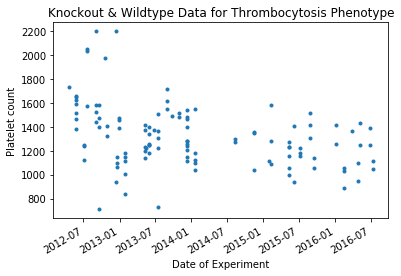

In [6]:
param = df4.loc[df4['parameter_stable_id'] == ParamId4Query, 'parameter_name'].iloc[0]
ax = df4.plot(x='datetime_for_experiment', y='data_point', style=".", legend = "", title= "Knockout & Wildtype Data for " + PhenoTerm.capitalize() + " Phenotype")
ax.set(xlabel='Date of Experiment', ylabel=param )

import matplotlib.pyplot as plt



/Users/fletcherc2/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


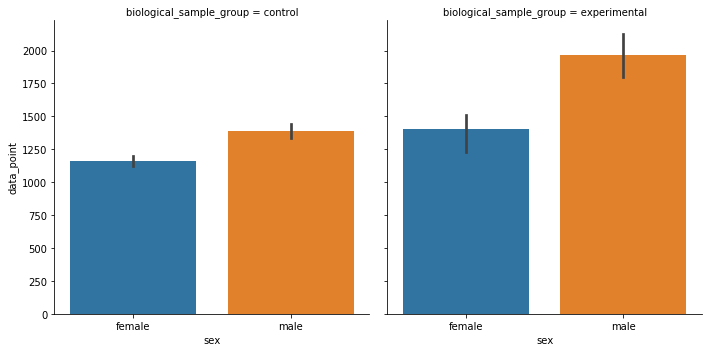

In [7]:
import seaborn as sns
x = df4['date_of_experiment']
y = df4['data_point']
sns.catplot(x = 'sex', y = 'data_point', col = 'biological_sample_group', kind = 'bar', data=df4)
plt.show()